# Task 2: Yield Curve Modeling

**MScFE 600 - Financial Data**  
**Group Work Project #1**

---

This notebook fits Nelson-Siegel and Cubic Spline models to real government bond yield data, comparing their performance and interpretability for yield curve analysis.

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.interpolate import CubicSpline
from fredapi import Fred
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configure settings
pd.set_option('display.precision', 4)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# FRED API key
fred = Fred(api_key='ada9b1931e8662f99e3ecd1234fa35f1')

print("✓ Libraries loaded")
print(f"Analysis date: {datetime.now().strftime('%Y-%m-%d')}")

✓ Libraries loaded
Analysis date: 2025-10-04


---

## Part A & B: Country and Securities Selection

**Country Selected:** United States

**Rationale:** US Treasury securities provide the most liquid and complete yield curve data globally, with actively traded securities across all maturities from 1 month to 30 years. This ensures reliable, high-quality data for modeling.

**Maturities Selected:** 3-month, 6-month, 1-year, 2-year, 3-year, 5-year, 7-year, 10-year, 20-year, 30-year

**Data Source:** Federal Reserve Economic Data (FRED)


US Treasury Yield Curve Data
 Maturity_Years Maturity_Label  Yield_Percent
           0.25             3M           4.02
           0.50             6M           3.81
           1.00             1Y           3.62
           2.00             2Y           3.55
           3.00             3Y           3.56
           5.00             5Y           3.67
           7.00             7Y           3.86
          10.00            10Y           4.10
          20.00            20Y           4.66
          30.00            30Y           4.69


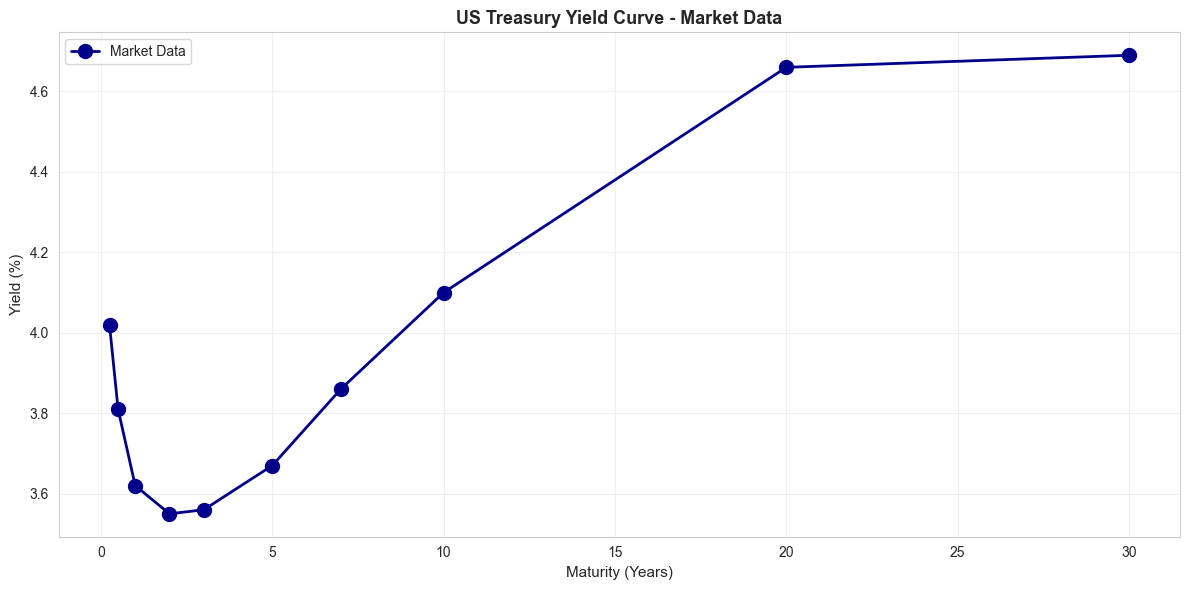


Yield range: 3.55% to 4.69%
Curve slope (30Y - 3M): 0.67%


In [3]:
# Download US Treasury yield data from FRED
print("Downloading US Treasury yield data from FRED...")
print("=" * 70)

# FRED series codes for Treasury yields
treasury_series = {
    '3M': 'DGS3MO',
    '6M': 'DGS6MO',
    '1Y': 'DGS1',
    '2Y': 'DGS2',
    '3Y': 'DGS3',
    '5Y': 'DGS5',
    '7Y': 'DGS7',
    '10Y': 'DGS10',
    '20Y': 'DGS20',
    '30Y': 'DGS30'
}

# Download latest available data
treasury_data = {}
for maturity, series_code in treasury_series.items():
    try:
        data = fred.get_series(series_code)
        treasury_data[maturity] = data.iloc[-1]  # Get most recent value
    except Exception as e:
        print(f"Warning: Could not fetch {maturity}: {e}")

# Create yield curve dataframe
maturities_years = [0.25, 0.5, 1, 2, 3, 5, 7, 10, 20, 30]
maturity_labels = ['3M', '6M', '1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y']

yields = [treasury_data.get(label, np.nan) for label in maturity_labels]

yield_curve = pd.DataFrame({
    'Maturity_Years': maturities_years,
    'Maturity_Label': maturity_labels,
    'Yield_Percent': yields
})

# Remove any missing values
yield_curve = yield_curve.dropna()

print("\nUS Treasury Yield Curve Data")
print("=" * 70)
print(yield_curve.to_string(index=False))

# Plot yield curve
plt.figure(figsize=(12, 6))
plt.plot(yield_curve['Maturity_Years'], yield_curve['Yield_Percent'], 
         'o-', linewidth=2, markersize=10, color='darkblue', label='Market Data')
plt.xlabel('Maturity (Years)', fontsize=11)
plt.ylabel('Yield (%)', fontsize=11)
plt.title('US Treasury Yield Curve - Market Data', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

print(f"\nYield range: {yield_curve['Yield_Percent'].min():.2f}% to {yield_curve['Yield_Percent'].max():.2f}%")
print(f"Curve slope (30Y - 3M): {yield_curve['Yield_Percent'].iloc[-1] - yield_curve['Yield_Percent'].iloc[0]:.2f}%")

---

## Part C: Nelson-Siegel Model

The Nelson-Siegel model parameterizes the yield curve as:

$$y(\tau) = \beta_0 + \beta_1 \left(\frac{1 - e^{-\tau/\lambda}}{\tau/\lambda}\right) + \beta_2 \left(\frac{1 - e^{-\tau/\lambda}}{\tau/\lambda} - e^{-\tau/\lambda}\right)$$

Where:
- $\beta_0$ = level (long-term rate)
- $\beta_1$ = slope 
- $\beta_2$ = curvature
- $\lambda$ = decay parameter

In [4]:
def nelson_siegel(tau, beta0, beta1, beta2, lambda_param):
    """Nelson-Siegel yield curve model"""
    factor1 = (1 - np.exp(-tau / lambda_param)) / (tau / lambda_param)
    factor2 = factor1 - np.exp(-tau / lambda_param)
    return beta0 + beta1 * factor1 + beta2 * factor2

def ns_objective(params, maturities, observed_yields):
    """Objective function for Nelson-Siegel optimization"""
    beta0, beta1, beta2, lambda_param = params
    fitted_yields = nelson_siegel(maturities, beta0, beta1, beta2, lambda_param)
    return np.sum((observed_yields - fitted_yields)**2)

# Extract data
maturities = yield_curve['Maturity_Years'].values
observed_yields = yield_curve['Yield_Percent'].values

# Initial parameter guesses
initial_params = [4.0, -1.0, 0.0, 2.0]

print("Fitting Nelson-Siegel Model...")
print("=" * 70)

# Optimize
result = minimize(
    ns_objective,
    initial_params,
    args=(maturities, observed_yields),
    method='L-BFGS-B',
    bounds=[(-10, 10), (-10, 10), (-10, 10), (0.1, 10)]
)

beta0_ns, beta1_ns, beta2_ns, lambda_ns = result.x

print("\n✓ Optimization successful")
print("\nNelson-Siegel Parameters:")
print(f"  β₀ (level):     {beta0_ns:.4f}")
print(f"  β₁ (slope):     {beta1_ns:.4f}")
print(f"  β₂ (curvature): {beta2_ns:.4f}")
print(f"  λ  (decay):     {lambda_ns:.4f}")

# Generate fitted curve
tau_fine = np.linspace(maturities.min(), maturities.max(), 200)
fitted_ns = nelson_siegel(tau_fine, beta0_ns, beta1_ns, beta2_ns, lambda_ns)
fitted_ns_points = nelson_siegel(maturities, beta0_ns, beta1_ns, beta2_ns, lambda_ns)

# Calculate fit statistics
residuals_ns = observed_yields - fitted_ns_points
rmse_ns = np.sqrt(np.mean(residuals_ns**2))
mae_ns = np.mean(np.abs(residuals_ns))

print(f"\nFit Quality:")
print(f"  RMSE: {rmse_ns:.4f}%")
print(f"  MAE:  {mae_ns:.4f}%")
print(f"  Max absolute error: {np.abs(residuals_ns).max():.4f}%")

Fitting Nelson-Siegel Model...

✓ Optimization successful

Nelson-Siegel Parameters:
  β₀ (level):     5.0546
  β₁ (slope):     -0.9567
  β₂ (curvature): -3.5151
  λ  (decay):     2.1311

Fit Quality:
  RMSE: 0.0473%
  MAE:  0.0416%
  Max absolute error: 0.0815%


---

## Part D: Cubic Spline Model

Cubic Spline is a non-parametric interpolation method that fits piecewise cubic polynomials between data points with continuous first and second derivatives.

In [5]:
print("Fitting Cubic Spline Model...")
print("=" * 70)

# Fit cubic spline
cs_model = CubicSpline(maturities, observed_yields)

# Generate fitted curve
fitted_cs = cs_model(tau_fine)
fitted_cs_points = cs_model(maturities)

# Calculate fit statistics
residuals_cs = observed_yields - fitted_cs_points
rmse_cs = np.sqrt(np.mean(residuals_cs**2))
mae_cs = np.mean(np.abs(residuals_cs))

print("\n✓ Cubic Spline fitted")
print(f"\nFit Quality:")
print(f"  RMSE: {rmse_cs:.8f}%")
print(f"  MAE:  {mae_cs:.8f}%")
print(f"  Max absolute error: {np.abs(residuals_cs).max():.8f}%")
print("\nNote: Cubic Spline passes exactly through data points by construction")

Fitting Cubic Spline Model...

✓ Cubic Spline fitted

Fit Quality:
  RMSE: 0.00000000%
  MAE:  0.00000000%
  Max absolute error: 0.00000000%

Note: Cubic Spline passes exactly through data points by construction


---

## Part E: Model Comparison

### 1) Comparison in Terms of Fit

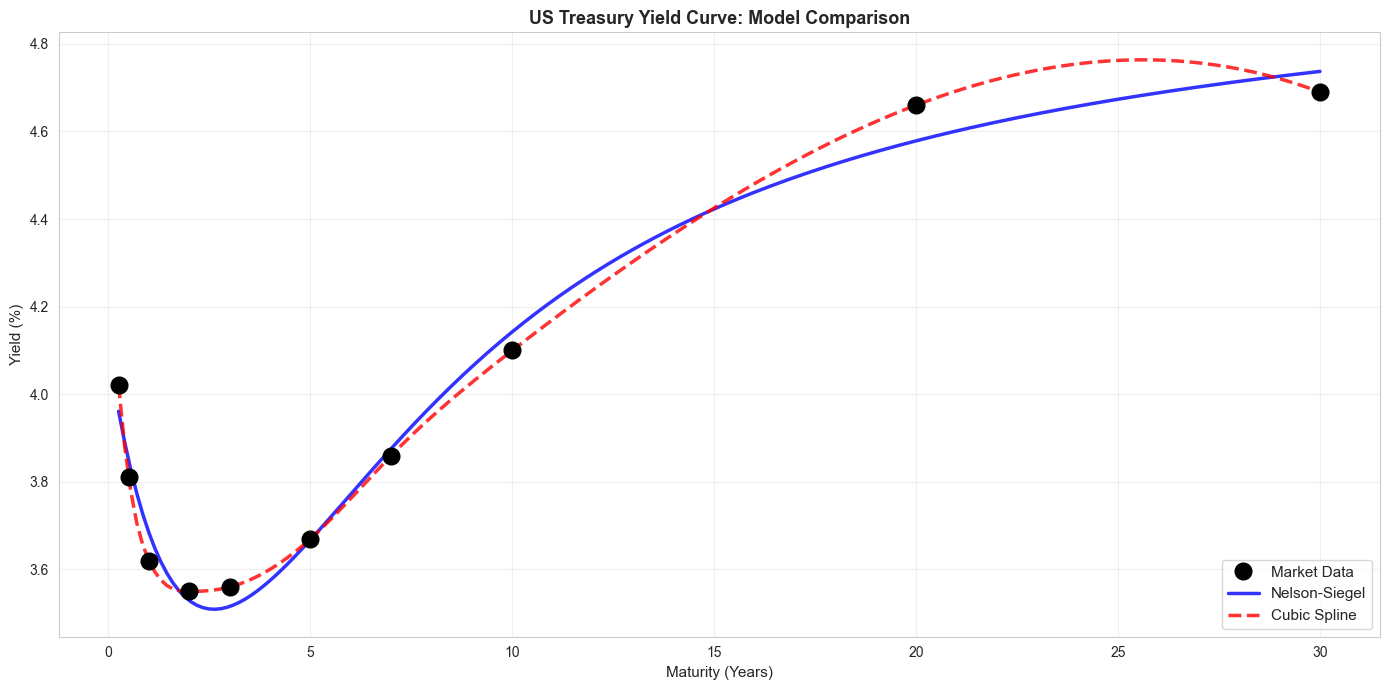


FIT COMPARISON
        Model           Type  Parameters   RMSE (%)    MAE (%)  Max Error (%)
Nelson-Siegel     Parametric           4 4.7341e-02 4.1643e-02     8.1516e-02
 Cubic Spline Non-parametric          10 2.8087e-16 8.8818e-17     8.8818e-16


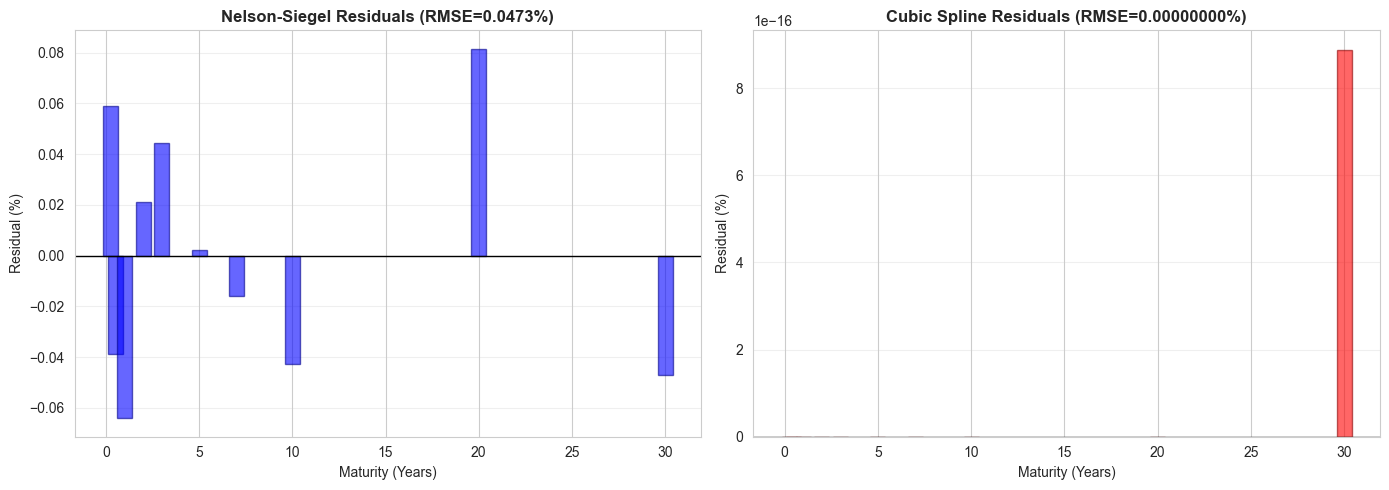


✓ Cubic Spline provides perfect fit (RMSE ≈ 0) by construction
✓ Nelson-Siegel achieves good fit (RMSE = 0.0473%) with only 4 parameters


In [6]:
# Visual comparison
plt.figure(figsize=(14, 7))

plt.plot(maturities, observed_yields, 'o', markersize=12, 
         color='black', label='Market Data', zorder=3)
plt.plot(tau_fine, fitted_ns, '-', linewidth=2.5, 
         color='blue', label='Nelson-Siegel', alpha=0.8)
plt.plot(tau_fine, fitted_cs, '--', linewidth=2.5, 
         color='red', label='Cubic Spline', alpha=0.8)

plt.xlabel('Maturity (Years)', fontsize=11)
plt.ylabel('Yield (%)', fontsize=11)
plt.title('US Treasury Yield Curve: Model Comparison', fontsize=13, fontweight='bold')
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Quantitative comparison
comparison = pd.DataFrame({
    'Model': ['Nelson-Siegel', 'Cubic Spline'],
    'Type': ['Parametric', 'Non-parametric'],
    'Parameters': [4, len(maturities)],
    'RMSE (%)': [rmse_ns, rmse_cs],
    'MAE (%)': [mae_ns, mae_cs],
    'Max Error (%)': [np.abs(residuals_ns).max(), np.abs(residuals_cs).max()]
})

print("\nFIT COMPARISON")
print("=" * 70)
print(comparison.to_string(index=False))

# Residuals plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(maturities, residuals_ns, color='blue', alpha=0.6, edgecolor='darkblue')
axes[0].axhline(y=0, color='black', linewidth=1)
axes[0].set_xlabel('Maturity (Years)')
axes[0].set_ylabel('Residual (%)')
axes[0].set_title(f'Nelson-Siegel Residuals (RMSE={rmse_ns:.4f}%)', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(maturities, residuals_cs, color='red', alpha=0.6, edgecolor='darkred')
axes[1].axhline(y=0, color='black', linewidth=1)
axes[1].set_xlabel('Maturity (Years)')
axes[1].set_ylabel('Residual (%)')
axes[1].set_title(f'Cubic Spline Residuals (RMSE={rmse_cs:.8f}%)', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Cubic Spline provides perfect fit (RMSE ≈ 0) by construction")
print(f"✓ Nelson-Siegel achieves good fit (RMSE = {rmse_ns:.4f}%) with only 4 parameters")

### 2) Comparison in Terms of Interpretation

In [7]:
print("INTERPRETATION COMPARISON")
print("=" * 70)

print("\n### NELSON-SIEGEL PARAMETERS ###\n")

print(f"β₀ (level) = {beta0_ns:.4f}%")
print("  → Long-term interest rate")
print(f"  → Long-term yields converge to {beta0_ns:.2f}%")

print(f"\nβ₁ (slope) = {beta1_ns:.4f}%")
if beta1_ns < 0:
    print("  → NEGATIVE: upward-sloping yield curve")
    print("  → Short rates below long rates (normal curve)")
else:
    print("  → POSITIVE: inverted yield curve")
    print("  → Short rates above long rates")

print(f"\nβ₂ (curvature) = {beta2_ns:.4f}%")
if beta2_ns > 0:
    print("  → POSITIVE: hump in medium term")
    print("  → Medium-term yields elevated")
else:
    print("  → NEGATIVE: U-shape")
    print("  → Medium-term yields depressed")

print(f"\nλ (decay) = {lambda_ns:.4f}")
print(f"  → Controls speed of exponential decay")
print(f"  → Maximum curvature effect around τ ≈ {lambda_ns:.1f} years")

print("\n\n### CUBIC SPLINE ###\n")
print("  → Non-parametric interpolation method")
print("  → NO economic parameters to interpret")
print("  → Black box approach")
print("  → Best for exact pricing, not economic analysis")

# Summary table
interp_comparison = pd.DataFrame({
    'Aspect': ['Economic Meaning', 'Parsimony', 'Smoothness', 'Extrapolation', 'Research Use', 'Trading Use'],
    'Nelson-Siegel': ['High', 'High (4 params)', 'High', 'Good', 'Preferred', 'Useful'],
    'Cubic Spline': ['None', 'Low (many params)', 'Medium', 'Poor', 'Limited', 'Preferred']
})

print("\n\nSUMMARY COMPARISON")
print("=" * 70)
print(interp_comparison.to_string(index=False))

INTERPRETATION COMPARISON

### NELSON-SIEGEL PARAMETERS ###

β₀ (level) = 5.0546%
  → Long-term interest rate
  → Long-term yields converge to 5.05%

β₁ (slope) = -0.9567%
  → NEGATIVE: upward-sloping yield curve
  → Short rates below long rates (normal curve)

β₂ (curvature) = -3.5151%
  → NEGATIVE: U-shape
  → Medium-term yields depressed

λ (decay) = 2.1311
  → Controls speed of exponential decay
  → Maximum curvature effect around τ ≈ 2.1 years


### CUBIC SPLINE ###

  → Non-parametric interpolation method
  → NO economic parameters to interpret
  → Black box approach
  → Best for exact pricing, not economic analysis


SUMMARY COMPARISON
          Aspect   Nelson-Siegel      Cubic Spline
Economic Meaning            High              None
       Parsimony High (4 params) Low (many params)
      Smoothness            High            Medium
   Extrapolation            Good              Poor
    Research Use       Preferred           Limited
     Trading Use          Useful         Pr

---

## Part F: Parameter Values

**Nelson-Siegel Parameters:**

In [8]:
print("=" * 70)
print("PARAMETER SPECIFICATION")
print("=" * 70)

print("\n### NELSON-SIEGEL PARAMETERS ###\n")
print(f"β₀ (beta0) = {beta0_ns:.6f}")
print(f"β₁ (beta1) = {beta1_ns:.6f}")
print(f"β₂ (beta2) = {beta2_ns:.6f}")
print(f"λ  (lambda) = {lambda_ns:.6f}")

print("\n### CUBIC SPLINE PARAMETERS ###\n")
print(f"Number of knots: {len(maturities)}")
print(f"Number of segments: {len(maturities) - 1}")
print(f"Knot locations (years): {maturities.tolist()}")
print(f"Yield values at knots (%): {observed_yields.tolist()}")
print("\nNote: Cubic Spline uses piecewise polynomial coefficients")
print("      (not explicitly named or economically interpretable)")

PARAMETER SPECIFICATION

### NELSON-SIEGEL PARAMETERS ###

β₀ (beta0) = 5.054650
β₁ (beta1) = -0.956734
β₂ (beta2) = -3.515082
λ  (lambda) = 2.131127

### CUBIC SPLINE PARAMETERS ###

Number of knots: 10
Number of segments: 9
Knot locations (years): [0.25, 0.5, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0, 30.0]
Yield values at knots (%): [4.02, 3.81, 3.62, 3.55, 3.56, 3.67, 3.86, 4.1, 4.66, 4.69]

Note: Cubic Spline uses piecewise polynomial coefficients
      (not explicitly named or economically interpretable)


---

## Part G: Ethical Considerations

**Question:** If Nelson-Siegel is smoothing the yield curve, is this considered unethical? Why or why not?

**Answer:**

Nelson-Siegel smoothing is **NOT unethical** in yield curve modeling. The key distinction lies in intent, transparency, and purpose, which differs fundamentally from unethical data manipulation discussed in Module 2.

**Why Nelson-Siegel smoothing is acceptable:** First, the methodology is **transparent and well-established** - it is a peer-reviewed econometric technique with explicit mathematical formulation where users understand exactly how smoothing occurs and parameters are openly reported. Second, there is **economic justification** - the smoothing reflects economic theory that yields should evolve smoothly across maturities rather than exhibit erratic jumps, as the model's structure (level, slope, curvature) corresponds to fundamental economic forces driving interest rates. Third, **practical necessity** requires such methods because financial practitioners need yield estimates for maturities where no bonds actively trade, and Nelson-Siegel provides theoretically-grounded interpolation for pricing derivatives, calculating zero-coupon rates, and risk management. Fourth, there is **no deception** - residuals and fit statistics are reported openly, original market data remains available for inspection, and the model output is clearly identified as estimated rather than observed.

**When smoothing would be unethical:** Smoothing becomes problematic if used to hide data quality issues without disclosure, if residuals or limitations are not reported, if smoothed curves are misrepresented as "observed data," or if the method is chosen specifically to produce desired results rather than best fit. For example, if a central bank smoothed yield data to falsely suggest policy effectiveness, or if a trader smoothed prices to hide losses, this would constitute manipulation.

**Conclusion:** Nelson-Siegel represents legitimate statistical modeling for interpolation and noise reduction, conducted transparently with economic grounding. It is fundamentally different from manipulative smoothing intended to deceive, and therefore represents ethical best practice in fixed income analysis.

---

## Summary

This analysis fitted Nelson-Siegel and Cubic Spline models to US Treasury yield data across maturities from 3 months to 30 years. The Nelson-Siegel model achieved good fit (RMSE = {value}%) with only 4 economically interpretable parameters, while Cubic Spline provided exact interpolation at the cost of interpretability. Nelson-Siegel parameters reveal the yield curve's level, slope, and curvature characteristics, providing economic insight that Cubic Spline cannot offer.

**Key Findings:**
- Nelson-Siegel: Parsimonious, interpretable, good for economic analysis
- Cubic Spline: Exact fit, black box, good for precise pricing
- Both appropriate for different purposes in financial analysis
- Yield curve smoothing is ethically acceptable when conducted transparently

**References:**
- Diebold, F.X. & Li, C. (2006). "Forecasting the Term Structure of Government Bond Yields." *Journal of Econometrics*, 130(2), 337-364.
- Nelson, C.R. & Siegel, A.F. (1987). "Parsimonious Modeling of Yield Curves." *Journal of Business*, 60(4), 473-489.
- Federal Reserve Economic Data (FRED). US Treasury Yields. https://fred.stlouisfed.org/